# Feature engineering and modeling

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import datetime
import os
import glob
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection, model_selection, metrics
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold

In [28]:
# Load data to a dataframe
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.shape

(110527, 14)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [30]:
#Processing PatientID column
## Check how many patients_ids are not integers
df[~ df.PatientId.apply(lambda x: x.is_integer())]

#Convert float to integer
def float_to_int(x):
    return int(x)


    

def set_df(df):
    '''Convert float to int
       And set appintmentID to index
    '''
    df["PatientId"].astype('int64')
    df.set_index('AppointmentID', inplace = True)
    
    return df
    

In [31]:
df  = set_df(df)

In [35]:
df["PatientId"] = df["PatientId"].apply(lambda x: float_to_int(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5642903 to 5629448
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientId       110527 non-null  int64 
 1   Gender          110527 non-null  object
 2   ScheduledDay    110527 non-null  object
 3   AppointmentDay  110527 non-null  object
 4   Age             110527 non-null  int64 
 5   Neighbourhood   110527 non-null  object
 6   Scholarship     110527 non-null  int64 
 7   Hipertension    110527 non-null  int64 
 8   Diabetes        110527 non-null  int64 
 9   Alcoholism      110527 non-null  int64 
 10  Handcap         110527 non-null  int64 
 11  SMS_received    110527 non-null  int64 
 12  No-show         110527 non-null  object
dtypes: int64(8), object(5)
memory usage: 11.8+ MB


## Feature engineering

### Process datetime object and extract new features from it.

In [36]:
#convert object to datetime and extract weekday from the datetime object
#
def convert_datetime(df):
    '''
    convert to datetime object,
    extract weekday and
    remove saturdays from data
    '''
    df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"], utc = True)
    df["AppointmentDay"]= pd.to_datetime(df["AppointmentDay"], utc = True)
    df["AppointmentDate"] = [datetime.datetime.date(d) for d in df["AppointmentDay"]]
    df["ScheduledDate"] = [datetime.datetime.date(d) for d in df["ScheduledDay"]]
    df['WeekdayScheduled'] = df.apply(lambda x: x.ScheduledDay.isoweekday(), axis = 1)
    df['WeekdayAppointment'] = df.apply(lambda x: x.AppointmentDay.isoweekday(), axis = 1)
    df["Weekday"] = df["AppointmentDay"].dt.weekday
    
    return df[df["Weekday"] != 5]

df = convert_datetime(df)       

In [37]:
# DaysBeforeCat to dummies

def awaitingdays(df):
    '''
    Calculate waiting days from the day of of scheduling
    '''
    df["AwaitingDays"] = ((df.AppointmentDate - df.ScheduledDate).dt.days) 
    return df[~ df["AwaitingDays"] < 0]

def AwaitingCat(days):
    if days == 0:
        return '0 days'
    elif days in range(1,3):
        return '1-2 days'
    elif days in range(3,8):
        return '3-7 days'
    elif days in range(8, 32):
        return '8-31 days'
    else:
        return '> 31 days'

#getting dummies for waiting category
def ant_days(df):
    df['0Days'] = (df['AwaitingCat'] == '0 days')*1
    df['1-2Days'] = (df['AwaitingCat'] == '1-2 days')*1
    df['3-7Days'] = (df['AwaitingCat'] == '3-7 days')*1
    df['8-31Days'] = (df['AwaitingCat'] == '8-31 days')*1
    df['32Days'] = (df['AwaitingCat'] == '> 31 days')*1
    return df


df = awaitingdays(df)
df['AwaitingCat'] = df["AwaitingDays"].apply(AwaitingCat)
df = ant_days(df)
df[:5]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,...,WeekdayScheduled,WeekdayAppointment,Weekday,AwaitingDays,AwaitingCat,0Days,1-2Days,3-7Days,8-31Days,32Days
AppointmentID,,,,,,,,,,,,,,,,,,,,,
5642903,29872499824296,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,...,5,5,4,0,0 days,1,0,0,0,0
5642503,558997776694438,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,...,5,5,4,0,0 days,1,0,0,0,0
5642549,4262962299951,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,...,5,5,4,0,0 days,1,0,0,0,0
5642828,867951213174,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,...,5,5,4,0,0 days,1,0,0,0,0
5642494,8841186448183,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,...,5,5,4,0,0 days,1,0,0,0,0


### How many missed appointments previously by the patients

In [43]:
#Pevious appointents how many booked by the patient before present scheduling day. 

df['PreviousApp']= (df.sort_values(by = ['PatientId','ScheduledDay'])
                       .groupby(['PatientId']).cumcount())
# give dummies to target variable
df["No-show"] = df["No-show"].map({'Yes': 1, 'No': 0})
#How many missed appintments are there from the previous appointments
df['MissedAppointments'] = (df.sort_values(['ScheduledDay'])
                                        .groupby(['PatientId'])['No-show'].cumsum())

In [46]:
#give dummies to Gender
df["Gender"] = df["Gender"].map({"M": 1, "F": 0})

### Group neighbourhood according to number of appointments in that area

In [47]:
#make a list of Neighbourhood based on their appointment frequency.
lessthanThousand = list(df["Neighbourhood"]
                     .value_counts()[df["Neighbourhood"]
                     .value_counts() < 1000].index)
Btn_1000_2000 = list(df["Neighbourhood"].value_counts()
                [(df["Neighbourhood"].value_counts() > 1000) & 
                (df["Neighbourhood"].value_counts() < 2000)].index)

Btn_2000_3000 = list(df["Neighbourhood"].value_counts()
                [(df["Neighbourhood"].value_counts() > 2000) & 
                (df["Neighbourhood"].value_counts() < 3000)].index)

Btn_3000_8000 = list(df["Neighbourhood"].value_counts()
                [(df["Neighbourhood"].value_counts() > 3000) & 
                (df["Neighbourhood"].value_counts() < 8000)].index)
print(len(lessthanThousand), len(Btn_1000_2000), len(Btn_2000_3000), len(Btn_3000_8000))

42 18 13 8


In [48]:
# fill the neibourhood name accordingly with frequency of appointments
df['lessthanthousand'] = df.Neighbourhood.isin(lessthanThousand)

df['lessthanthousand'] = (df
                         .apply(lambda x: 'lessthanThousand' if x.lessthanthousand else "NA", axis=1))

df['Btn_1000_2000'] = df.Neighbourhood.isin(Btn_1000_2000)

df['Btn_1000_2000'] = (df
                         .apply(lambda x: 'Btn_1000_2000' if x.Btn_1000_2000 else "NA", axis=1))


df['Btn_2000_3000'] = df.Neighbourhood.isin(Btn_2000_3000)

df['Btn_2000_3000'] = (df
                         .apply(lambda x: 'Btn_2000_3000' if x.Btn_2000_3000 else "NA", axis=1))


df['Btn_3000_8000'] = df.Neighbourhood.isin(Btn_3000_8000)

df['Btn_3000_8000'] = (df
                         .apply(lambda x: 'Btn_3000_8000' if x.Btn_3000_8000 else "NA", axis=1))


# Select the target variable and drop it from the df for data wrangling
df["lessthanthousand"] = df["lessthanthousand"].map({'lessthanThousand': 1, 'NA': 0})
df["Btn_1000_2000"] = df["Btn_1000_2000"].map({"Btn_1000_2000": 1, "NA": 0})
df["Btn_2000_3000"] = df["Btn_2000_3000"].map({"Btn_2000_3000":1, "NA": 0})
df["Btn_3000_8000"] = df["Btn_3000_8000"].map({"Btn_3000_8000":1, "NA": 0})


### Group Hypertension, diabetes and alcoholism as one and Handicap as one group

In [49]:
#Club all diseases to having a disease
df['PreviousDisease'] = df.apply(lambda x: ((x.Hipertension == 1 )| x.Diabetes == 1 | x.Alcoholism == 1)*1, axis = 1)

In [50]:
#From different type or grades of handicap we made a new feature 
#wether person has handiccap or not
def HasHandicap(x):
    '''To make all categories of handicap into one group'''
    if x >= 1:
        return 1
    else:
        return 0
df['HasHandicap'] = df['Handcap'].apply(lambda x: HasHandicap(x))

In [124]:
df2 = df[(df['WeekdayScheduled'] < 6) &
             (df['WeekdayAppointment'] < 6) &
             (df['Age'] >= 0) &
             (df['AwaitingDays'] >= 0)]
    
df2.shape

(110466, 34)

In [73]:
df2["0Days"].unique()

array([1, 0])

## Modeling

In [125]:
# WeekdayAppointment to dummies
df2 = df2.assign(AppointmentMonday = (df2['WeekdayAppointment'] == 1)*1, 
                 AppointmentTuesday = (df2['WeekdayAppointment'] == 2)*1, 
                 AppointmentWednesday = (df2['WeekdayAppointment'] == 3)*1,
                 AppointmentThursday = (df2['WeekdayAppointment'] == 4)*1,
                 AppointmentFriday = (df2['WeekdayAppointment'] == 5)*1)  

In [82]:
df2.shape

(110466, 38)

In [67]:
df2.columns

Index(['PatientId', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age',
       'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'AppointmentDate',
       'ScheduledDate', 'WeekdayScheduled', 'WeekdayAppointment', 'Weekday',
       'AwaitingDays', 'AwaitingCat', '0Days', '1-2Days', '3-7Days',
       '8-31Days', '32Days', 'PreviousApp', 'PreviousNoShow',
       'lessthanthousand', 'Btn_1000_2000', 'Btn_2000_3000', 'Btn_3000_8000',
       'PreviousDisease', 'HasHandicap', 'AppointmentMonday',
       'AppointmentTuesday', 'AppointmentWednesday', 'AppointmentThursday',
       'AppointmentFriday'],
      dtype='object')

In [93]:
df2["PreviousNoShow"] = df2["PreviousNoShow"].replace("NaN", 0, inplace = True)

In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110466 entries, 5642903 to 5629448
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   PatientId             110466 non-null  int64              
 1   Gender                110466 non-null  int64              
 2   ScheduledDay          110466 non-null  datetime64[ns, UTC]
 3   AppointmentDay        110466 non-null  datetime64[ns, UTC]
 4   Age                   110466 non-null  int64              
 5   Neighbourhood         110466 non-null  object             
 6   Scholarship           110466 non-null  int64              
 7   Hipertension          110466 non-null  int64              
 8   Diabetes              110466 non-null  int64              
 9   Alcoholism            110466 non-null  int64              
 10  Handcap               110466 non-null  int64              
 11  SMS_received          110466 non-null  int64 

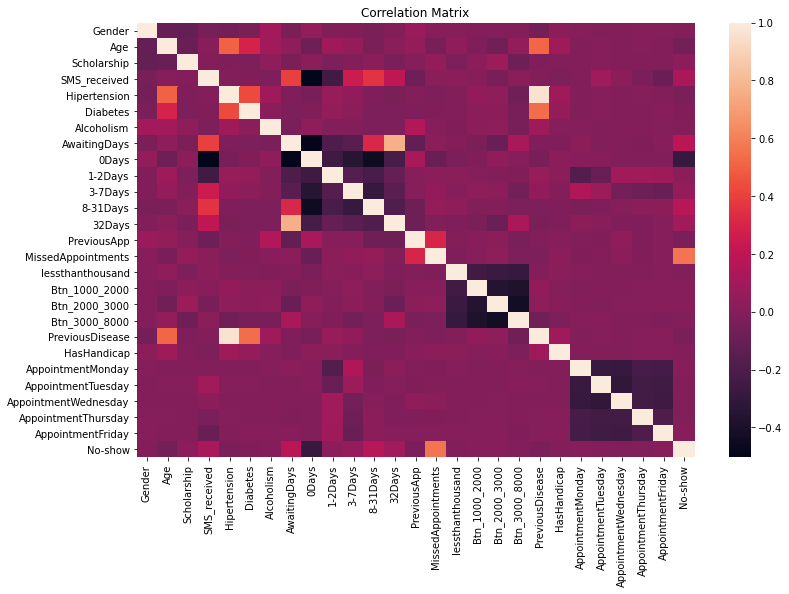

,Gender,Age,Scholarship,SMS_received,Hipertension,Diabetes,Alcoholism,AwaitingDays,0Days,1-2Days,...,Btn_2000_3000,Btn_3000_8000,PreviousDisease,HasHandicap,AppointmentMonday,AppointmentTuesday,AppointmentWednesday,AppointmentThursday,AppointmentFriday,No-show
Gender,1.000000,-0.106476,-0.114282,-0.046217,-0.055796,-0.032665,0.106178,-0.028392,0.051669,-0.011060,...,0.000093,-0.000928,-0.053275,0.022302,0.003951,-0.009389,-0.002302,0.004838,0.004201,-0.004151
Age,-0.106476,1.000000,-0.092419,0.012667,0.504519,0.292288,0.095851,0.034943,-0.083504,0.090509,...,-0.064023,0.049936,0.514489,0.083916,-0.005596,0.004228,-0.000801,0.002905,-0.000633,-0.060433
Scholarship,-0.114282,-0.092419,1.000000,0.001131,-0.019621,-0.024825,0.035064,-0.030585,0.025440,-0.025392,...,0.078377,-0.081438,-0.019453,-0.009056,-0.000882,0.002989,-0.000367,-0.003167,0.001058,0.029231
SMS_received,-0.046217,0.012667,0.001131,1.000000,-0.006129,-0.014509,-0.026098,0.398143,-0.503501,-0.239226,...,-0.043520,0.015920,-0.008035,-0.025255,-0.007008,0.099986,0.025461,-0.036870,-0.097423,0.126566
Hipertension,-0.055796,0.504519,-0.019621,-0.006129,1.000000,0.433091,0.087985,-0.017070,-0.039946,0.062724,...,0.033907,-0.071823,0.960210,0.085065,-0.004967,0.004120,-0.003165,0.004259,0.000165,-0.035752
Diabetes,-0.032665,0.292288,-0.024825,-0.014509,0.433091,1.000000,0.018547,-0.027110,-0.015010,0.048857,...,0.022912,-0.042148,0.538975,0.059293,-0.005282,0.002809,-0.002873,-0.003431,0.009036,-0.015280
Alcoholism,0.106178,0.095851,0.035064,-0.026098,0.087985,0.018547,1.000000,-0.038514,0.040490,-0.006037,...,0.032805,-0.042286,0.090004,0.003731,0.001793,-0.005154,0.000466,-0.000900,0.004187,-0.000132
AwaitingDays,-0.028392,0.034943,-0.030585,0.398143,-0.017070,-0.027110,-0.038514,1.000000,-0.488855,-0.196625,...,-0.095969,0.120081,-0.020013,-0.020912,0.021847,-0.005883,-0.007943,-0.016096,0.007578,0.186439
0Days,0.051669,-0.083504,0.025440,-0.503501,-0.039946,-0.015010,0.040490,-0.488855,1.000000,-0.254727,...,0.037062,0.004409,-0.040432,0.020343,0.009727,0.010305,-0.009203,-0.005095,-0.006715,-0.283504
1-2Days,-0.011060,0.090509,-0.025392,-0.239226,0.062724,0.048857,-0.006037,-0.196625,-0.254727,1.000000,...,-0.002122,-0.014579,0.064662,0.013745,-0.176960,-0.096919,0.101234,0.097757,0.090266,0.021876


In [126]:
#Finding correlation between features
features = [ 'Gender', 'Age', 'Scholarship', 'SMS_received', 'Hipertension', 'Diabetes',
       'Alcoholism', 'AwaitingDays', '0Days', '1-2Days', '3-7Days',
       '8-31Days', '32Days', 'PreviousApp', 'MissedAppointments',
       'lessthanthousand', 'Btn_1000_2000', 'Btn_2000_3000', 'Btn_3000_8000',
       'PreviousDisease', 'HasHandicap', 'AppointmentMonday',
       'AppointmentTuesday', 'AppointmentWednesday', 'AppointmentThursday',
       'AppointmentFriday', 'No-show']

corr = df2[features].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Correlation Matrix')
plt.gcf().set_size_inches(12.5, 8)
plt.show()

corr

In [127]:
features = ['Gender', 'Age', 'Scholarship', 'SMS_received', 'Hipertension', 'Diabetes',
       'Alcoholism', 'AwaitingDays', '0Days', '1-2Days', '3-7Days',
       '8-31Days', '32Days', 'PreviousApp', 'MissedAppointments', 
       'lessthanthousand', 'Btn_1000_2000', 'Btn_2000_3000', 'Btn_3000_8000',
       'PreviousDisease', 'HasHandicap', 'AppointmentMonday',
       'AppointmentTuesday', 'AppointmentWednesday', 'AppointmentThursday',
       'AppointmentFriday']
scaler = StandardScaler()
df2_rescaled = pd.DataFrame(scaler.fit_transform(df2[features]), columns= features)

X_train, X_test, y_train, y_test = train_test_split(df2_rescaled, df2["No-show"], 
                                                    test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape)

(88372, 26) (22094, 26)


In [128]:
#Let's choose class weights of better score and run model again
lg = LogisticRegression(class_weight={0: 1, 1: 3})
lg.fit(X_train, y_train)
lg.score(X_train, y_train)
lg_y_pred = lg.predict(X_test)
print(accuracy_score(y_test, lg_y_pred),
      precision_score(y_test, lg_y_pred),
      recall_score(y_test, lg_y_pred),
      f1_score(y_test, lg_y_pred))

0.9378111704535168 0.7888290963072926 0.9474036104301314 0.8608748481166464


In [100]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot= True, fmt="d", cmap = 'Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
   
    plt.ylabel('True label', fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)
    return fig



Logistic regression confusion matrix: 

 [[16469  1138]
 [  236  4251]]


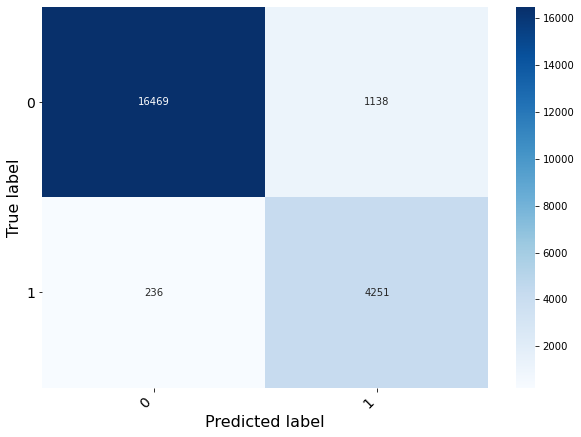

In [129]:
#Plot confusion matrix
print("Logistic regression confusion matrix: \n\n", confusion_matrix(y_test, lg.predict(X_test)))
cm = print_confusion_matrix(confusion_matrix(y_test, lg.predict(X_test)), ['0', '1'])

In [145]:
#Logistic regression with different class weights
classweights = ["balanced",{0:1, 1:2}, {0:1, 1:3}, {0:1, 1:5}]
solvers = ["liblinear", "newton-cg", "lbfgs"]
C_parm = [0.1,1,10]
for w in classweights:
    for s in solvers:
        for c in C_parm:
            lg = LogisticRegression(class_weight = w, solver=s, C=c)
            lg.fit(X_train, y_train)
            print(f'{w}{s}{c}:{lg.score(X_train, y_train)}') 

balancedliblinear0.1:0.9334404562531119
balancedliblinear1:0.933678088082198
balancedliblinear10:0.933700719684968
balancednewton-cg0.1:0.933463087855882
balancednewton-cg1:0.933678088082198
balancednewton-cg10:0.933700719684968
balancedlbfgs0.1:0.933463087855882
balancedlbfgs1:0.933678088082198
balancedlbfgs10:0.933700719684968
{0: 1, 1: 2}liblinear0.1:0.9336328248766578
{0: 1, 1: 2}liblinear1:0.933881772507129
{0: 1, 1: 2}liblinear10:0.9339157199112841
{0: 1, 1: 2}newton-cg0.1:0.9336101932738876
{0: 1, 1: 2}newton-cg1:0.9338704567057439
{0: 1, 1: 2}newton-cg10:0.9339157199112841
{0: 1, 1: 2}lbfgs0.1:0.9336101932738876
{0: 1, 1: 2}lbfgs1:0.933881772507129
{0: 1, 1: 2}lbfgs10:0.9339157199112841
{0: 1, 1: 3}liblinear0.1:0.9351038790567148
{0: 1, 1: 3}liblinear1:0.9352283528719504
{0: 1, 1: 3}liblinear10:0.9352283528719504
{0: 1, 1: 3}newton-cg0.1:0.9351038790567148
{0: 1, 1: 3}newton-cg1:0.9352170370705654
{0: 1, 1: 3}newton-cg10:0.9352283528719504
{0: 1, 1: 3}lbfgs0.1:0.935103879056714

In [133]:
#Let's choose class weights of better score and run model again
lg = LogisticRegression(class_weight={0:1, 1:3}, solver= "lbfgs")
lg.fit(X_train, y_train)
lg.score(X_train, y_train)
lg_y_pred = lg.predict(X_test)
print(accuracy_score(y_test, lg_y_pred),
      precision_score(y_test, lg_y_pred),
      recall_score(y_test, lg_y_pred),
      f1_score(y_test, lg_y_pred))

0.9378111704535168 0.7888290963072926 0.9474036104301314 0.8608748481166464


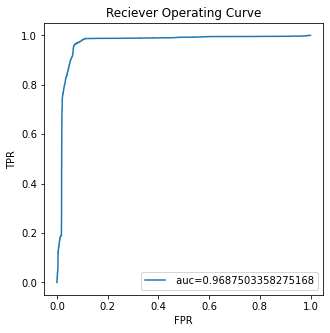

In [134]:
prob = lg.predict_proba(X_test)[:,1]
plt.figure(figsize = (5, 5))
fpr_log, tpr_log, thresholds = roc_curve(y_test,prob)
auc = np.trapz(tpr_log,fpr_log)
plt.plot(fpr_log,tpr_log,label=" auc="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Reciever Operating Curve')
plt.legend(loc=4)
plt.show()

### Logistic model with cross_validation 

In [140]:
features = ['Gender', 'Age', 'Scholarship', 'SMS_received', 'Hipertension', 'Diabetes',
       'Alcoholism', 'AwaitingDays', '0Days', '1-2Days', '3-7Days',
       '8-31Days', '32Days', 'PreviousApp', 'MissedAppointments', 
       'lessthanthousand', 'Btn_1000_2000', 'Btn_2000_3000', 'Btn_3000_8000',
       'PreviousDisease', 'HasHandicap', 'AppointmentMonday',
       'AppointmentTuesday', 'AppointmentWednesday', 'AppointmentThursday',
       'AppointmentFriday']
scaler = StandardScaler()
df2_rescaled = pd.DataFrame(scaler.fit_transform(df2[features]), columns= features)

X_train, X_test, y_train, y_test = train_test_split(df2_rescaled, df2["No-show"], 
                                                    test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(88372, 26) (22094, 26) (88372,) (22094,)


In [172]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
lg_cv = LogisticRegression(class_weight={0:1, 1:3}, solver= 'liblinear', ) 
k_fold = KFold(n_splits=5, shuffle=True, random_state=1)
print(np.mean(cross_val_score(lg_cv, X_train, y_train, cv = k_fold, scoring="accuracy")))


0.9350133371021514


In [174]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(lg_cv, X_test, y_test,  cv=10)
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[16461,  1146],
       [  233,  4254]])

### Test score 

In [175]:
lg_cv.fit(X_train, y_train)
y_pred = lg_cv.predict(X_test)
print(accuracy_score(y_test, y_pred),
      precision_score(y_test, y_pred),
      recall_score(y_test, y_pred),
      f1_score(y_test, y_pred))


0.9378111704535168 0.7888290963072926 0.9474036104301314 0.8608748481166464


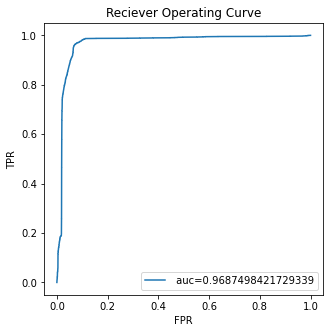

In [176]:
prob = lg_cv.predict_proba(X_test)[:,1]
plt.figure(figsize = (5, 5))
fpr_log, tpr_log, thresholds = roc_curve(y_test,prob)
auc = np.trapz(tpr_log,fpr_log)
plt.plot(fpr_log,tpr_log,label=" auc="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Reciever Operating Curve')
plt.legend(loc=4)
plt.show()

Logistic regression confusion matrix: 

 [[16469  1138]
 [  236  4251]]


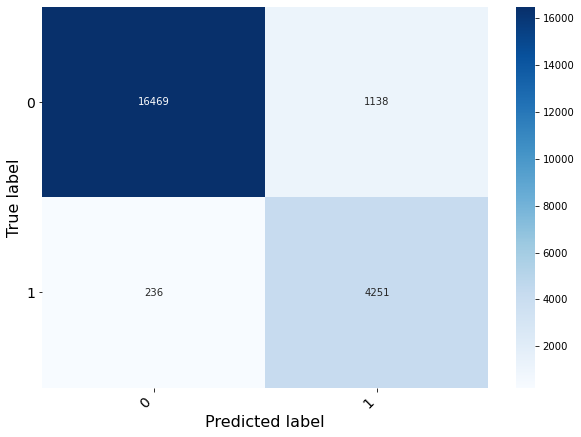

In [177]:
#Plot confusion matrix
print("Logistic regression confusion matrix: \n\n", confusion_matrix(y_test, lg_cv.predict(X_test)))
cm = print_confusion_matrix(confusion_matrix(y_test, lg_cv.predict(X_test)), ['0', '1'])

